# Whitened PSD

* **author**: steeve.laquitaine@epfl.ch

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Horvath` (aligned with cortical column)
        * rat cortex S1
        * 128ch
        * 30.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)
    * `high-density (Horvath)` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)
        * fitted gain and noise + fine tuned gain
        * Silico probe 1
            * duration: 1175.9988 secs (~28 min)
        * Silico probe 2   
            * duration: 1714.99825 secs (~19 min)
        * Silico probe 3: 
            * duration: 1763.9982 secs  (~29 min)
    * `Buccino`:
        * 10 min
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/validation/main/marques/psd_buttw_noise_fitd_gain_ftd_10perc_less_raw_welch.sbatch (4m)

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ_HV = 20000          # sampling frequency
SFREQ_HS = 20000        # sampling frequency
SFREQ_MV = 30000          # sampling frequency
SFREQ_MS = 40000        # sampling frequency
SFREQ_B = 32000

# SETUP DATASET COMFIG
# marques
cfg_mv, _ = get_config("vivo_marques", "c26").values()
RAW_PATH_mv = cfg_mv["probe_wiring"]["output"]
PREP_PATH_mv = cfg_mv["preprocessing"]["output"]["trace_file_path"]

# horvath
cfg_hv, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv = cfg_hv["probe_wiring"]["output"]
PREP_PATH_hv = cfg_hv["preprocessing"]["output"]["trace_file_path"]

# marques silico 
cfg_ms, _ = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_ms = cfg_ms["probe_wiring"]["output"]
PREP_PATH_ms = cfg_ms["preprocessing"]["output"]["trace_file_path"]

# horvath silico 
cfg_hs, _ = get_config(
    "silico_horvath", "concatenated/probe_2"
).values()
RAW_PATH_hs = cfg_hs["probe_wiring"]["output"]
PREP_PATH_hs = cfg_hs["preprocessing"]["output"]["trace_file_path"]

# Buccino with fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["raw_gain_ftd"]
PREP_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["prep_gain_ftd"]

# FIGURE SETTINGS
#FIG_SIZE = (8.5, 4)
#FIG_SIZE = (14, 4)
FIG_SIZE = (1.05, 1.05)
COLOR_HV = [0.75, 0.75, 0.75] # light
COLOR_MV = [0.4, 0.4, 0.4]
COLOR_HS = [0.9, 0.64, 0.65] # light
COLOR_MS = [0.9, 0.14, 0.15]

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.3
plt.rcParams["axes.linewidth"] = 0.3 #1
plt.rcParams["axes.spines.top"] = False
#plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.major.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
#YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

2024-06-17 09:24:23,633 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 09:24:23,731 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 09:24:23,733 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 09:24:23,750 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 09:24:23,751 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 09:24:23,934 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 09:24:23,936 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 09:24:23,972 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 09:24:23,976 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 09:24:24,042 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (1s)Load dataset

* select first 10 min for speed

In [2]:
# Load traces
# horvath
RawHV = si.load_extractor(RAW_PATH_hv)
RawHS = si.load_extractor(RAW_PATH_hs)
PrepHV = si.load_extractor(PREP_PATH_hv)
PrepHS = si.load_extractor(PREP_PATH_hs)

# marques
RawMV = si.load_extractor(RAW_PATH_mv)
RawMS = si.load_extractor(RAW_PATH_ms)
PrepMV = si.load_extractor(PREP_PATH_mv)
PrepMS = si.load_extractor(PREP_PATH_ms)

# select first 10 minutes
# horvath
RawHV = RawHV.frame_slice(start_frame=0, end_frame=SFREQ_HV * 10 * 60)
RawHS = RawHS.frame_slice(start_frame=0, end_frame=SFREQ_HS * 10 * 60)
PrepHV = PrepHV.frame_slice(start_frame=0, end_frame=SFREQ_HV * 10 * 60)
PrepHS = PrepHS.frame_slice(start_frame=0, end_frame=SFREQ_HS * 10 * 60)
# marques
RawMV = RawMV.frame_slice(start_frame=0, end_frame=SFREQ_MV * 10 * 60)
RawMS = RawMS.frame_slice(start_frame=0, end_frame=SFREQ_MS * 10 * 60)
PrepMV = PrepMV.frame_slice(start_frame=0, end_frame=SFREQ_MV * 10 * 60)
PrepMS = PrepMS.frame_slice(start_frame=0, end_frame=SFREQ_MS * 10 * 60)

# traces
raw_hv, pre_hv, raw_mv, pre_mv, raw_hs, pre_hs, raw_ms, pre_ms = (
    power.load_saved_traces_in_ctx()
)
# psds
(
    psd_raw_hv,
    psd_pre_hv,
    psd_raw_mv,
    psd_pre_mv,
    psd_raw_hs,
    psd_pre_hs,
    psd_raw_ms,
    psd_pre_ms,
) = power.load_psd_results()

# psd Buccino (layer 5)
psd_raw_b = np.load(RAW_PATH_GAIN_FTD_B, allow_pickle=True).item()
psd_pre_b = np.load(PREP_PATH_GAIN_FTD_B, allow_pickle=True).item()

# sanity check
assert RawHS.get_total_duration() == 10 * 60, "not 10 min"
assert RawHV.get_total_duration() == 10 * 60, "not 10 min"
assert RawMV.get_total_duration() == 10 * 60, "not 10 min"
assert RawMS.get_total_duration() == 10 * 60, "not 10 min"
assert PrepHS.get_total_duration() == 10 * 60, "not 10 min"
assert PrepHV.get_total_duration() == 10 * 60, "not 10 min"
assert PrepMV.get_total_duration() == 10 * 60, "not 10 min"
assert PrepMS.get_total_duration() == 10 * 60, "not 10 min"

# unit-test
assert psd_raw_hv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_mv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_mv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_b["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_b["freq"][1] == 1.0, "psd resolution should be 1Hz"

### Validate amplitude

#### (1s)Keep cortical sites

In [3]:
# Keep traces from good sites (in cortex)

# SILICO

# horvath
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_hs = RawHS.get_property("layers")
site_layers_hs = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_hs
]
IN_CTX = np.isin(site_layers_hs, layers)
sites_hs = np.where(IN_CTX)[0]
# marques
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_ms = RawMS.get_property("layers")
site_layers_ms = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_ms
]
IN_CTX = np.isin(site_layers_ms, layers)
sites_ms = np.where(IN_CTX)[0]

# VIVO

# horvath
site_layers_hv = RawHV.get_property("layers")
IN_CTX = np.isin(site_layers_hv, layers)
sites_hv = np.where(IN_CTX)[0]
# marques
site_layers_mv = RawMV.get_property("layers")
IN_CTX = np.isin(site_layers_mv, layers)
sites_mv = np.where(IN_CTX)[0]

# keep only the layers
site_layers_hs = np.array(site_layers_hs)[sites_hs]
site_layers_hv = np.array(site_layers_hv)[sites_hv]
site_layers_ms = np.array(site_layers_ms)[sites_ms]
site_layers_mv = np.array(site_layers_mv)[sites_mv]

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

### Plot

compute plot

In [5]:
# calculate psd plot stats
(
    psd_mean_hv,
    psd_mean_mv,
    psd_mean_hs,
    psd_mean_ms,
    psd_mean_b,
    psd_mean_pre_hv,
    psd_mean_pre_mv,
    psd_mean_pre_hs,
    psd_mean_pre_ms,
    psd_mean_pre_b,
    ci_raw_hv,
    ci_raw_mv,
    ci_raw_hs,
    ci_raw_ms,
    ci_raw_b,
    ci_pre_hv,
    ci_pre_mv,
    ci_pre_hs,
    ci_pre_ms,
    ci_pre_b,
) = power.get_psd_plot_mean_and_ci(
    psd_raw_hv,
    psd_raw_mv,
    psd_raw_hs,
    psd_raw_ms,
    psd_raw_b,
    psd_pre_hv,
    psd_pre_mv,
    psd_pre_hs,
    psd_pre_ms,
    psd_pre_b,
)

plot avg

    silico:
        first band: 0-70Hz -> better 0 - 90Hz
        2nd band: 70 - 2000 --> better 0 - 110Hz
        2nd band: 2500 - 200Nyquist

Normalizing psds, plotting three on the left y-scale and horvath vivo on a different y-scale was the only way to compare all psds on the same plot.

In [6]:
# plot params
SIZE = 1
pm = {
    "linestyle": "-",
    "marker": "o",
    "markersize": SIZE,
    "rasterized": True,
}
plt.rcParams["axes.spines.right"] = True

mean alpha: -1.7035997464836283
std alpha: 0.12790398288270627
n= 128
mean alpha: -0.7628911035210819
std alpha: 0.19242451357711407
n= 226
mean alpha: -0.8644752095517861
std alpha: 0.2880759864174182
n= 202
mean alpha: -0.5654625962939277
std alpha: 0.13279220192753696
n= 128


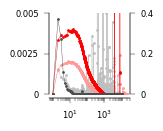

In [7]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)
# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv = power.plot_whitened(
    ax2,
    psd_raw_hv,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_mv = power.plot_whitened(
    ax1,
    psd_raw_mv,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_ms = power.plot_whitened(
    ax1, psd_raw_ms, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_hs = power.plot_whitened(
    ax1,
    psd_raw_hs,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)


# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened.svg", **savefig_cfg)

#### plot layer 1 (No layer 1 on probe 2)

#### plot layer 2/3

In [8]:
# get L2/3 data
layer = "L2_3"
psd_raw_hv2 = copy.copy(psd_raw_hv)
psd_raw_hv2["power"] = psd_raw_hv2["power"][site_layers_hv == layer, :]
psd_raw_mv2 = copy.copy(psd_raw_mv)
psd_raw_mv2["power"] = psd_raw_mv2["power"][site_layers_mv == layer, :]
psd_raw_ms2 = copy.copy(psd_raw_ms)
psd_raw_ms2["power"] = psd_raw_ms2["power"][site_layers_ms == layer, :]
psd_raw_hs2 = copy.copy(psd_raw_hs)
psd_raw_hs2["power"] = psd_raw_hs2["power"][site_layers_hs == layer, :]

mean alpha: -1.7023305522238443
std alpha: 0.03736015217902441
n= 8
mean alpha: -0.642920431097683
std alpha: 0.10957473198673377
n= 42
mean alpha: -0.8113001320030907
std alpha: 0.07305198901338655
n= 47
mean alpha: -0.5789002506852488
std alpha: 0.10839162988034134
n= 8


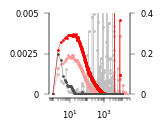

In [9]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv_l23 = power.plot_whitened(
    ax2,
    psd_raw_hv2,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_mv2,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_l23 = power.plot_whitened(
    ax1, psd_raw_ms2, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_hs2,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened_l23.svg", **savefig_cfg)

#### plot layer 4

In [11]:
# get L2/3 data
layer = "L4"
psd_raw_hv2 = copy.copy(psd_raw_hv)
psd_raw_hv2["power"] = psd_raw_hv2["power"][site_layers_hv == layer, :]
psd_raw_mv2 = copy.copy(psd_raw_mv)
psd_raw_mv2["power"] = psd_raw_mv2["power"][site_layers_mv == layer, :]
psd_raw_ms2 = copy.copy(psd_raw_ms)
psd_raw_ms2["power"] = psd_raw_ms2["power"][site_layers_ms == layer, :]
psd_raw_hs2 = copy.copy(psd_raw_hs)
psd_raw_hs2["power"] = psd_raw_hs2["power"][site_layers_hs == layer, :]

mean alpha: -1.6372002369343175
std alpha: 0.056419714184202094
n= 20
mean alpha: -0.5759256977509644
std alpha: 0.062132371669562474
n= 34
mean alpha: -1.1042105951833348
std alpha: 0.05517879714660059
n= 19
mean alpha: -0.5391314160898916
std alpha: 0.17859868648734642
n= 32


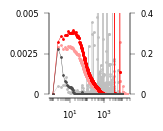

In [12]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv_l23 = power.plot_whitened(
    ax2,
    psd_raw_hv2,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_mv2,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_l23 = power.plot_whitened(
    ax1, psd_raw_ms2, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_hs2,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened_l4.svg", **savefig_cfg)

#### plot layer 5

In [13]:
layer = "L5"
psd_raw_hv2 = copy.copy(psd_raw_hv)
psd_raw_hv2["power"] = psd_raw_hv2["power"][site_layers_hv == layer, :]
psd_raw_mv2 = copy.copy(psd_raw_mv)
psd_raw_mv2["power"] = psd_raw_mv2["power"][site_layers_mv == layer, :]
psd_raw_ms2 = copy.copy(psd_raw_ms)
psd_raw_ms2["power"] = psd_raw_ms2["power"][site_layers_ms == layer, :]
psd_raw_hs2 = copy.copy(psd_raw_hs)
psd_raw_hs2["power"] = psd_raw_hs2["power"][site_layers_hs == layer, :]

mean alpha: -1.7166507879368011
std alpha: 0.14397701813437566
n= 88
mean alpha: -0.7848512404482271
std alpha: 0.11476243262791487
n= 42
mean alpha: -1.2396219866798182
std alpha: 0.05259682480548953
n= 52
mean alpha: -0.5738159659689115
std alpha: 0.11244397886082681
n= 88


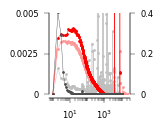

In [14]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv_l23 = power.plot_whitened(
    ax2,
    psd_raw_hv2,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_mv2,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_l23 = power.plot_whitened(
    ax1, psd_raw_ms2, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_hs2,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened_l5.svg", **savefig_cfg)

#### plot layer 6 (None on probe 2)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
